# Image Style Transfer using CNN


En este notebook se *recreara* el meotodo de style transfer descrito en el paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) en PyTorch.

Este paper, style transfer utiliza las extracción de features  que se encuentran en la en las diferentes capas de la arquitectura de CNN VGG-19, compuesta de varias capas convoluciobales, algunas capas de agrupación y de algunas capas totalmente conectadas. En la imagen siguiente, las capas convolucionales se nombran por gripo y su orden en la pila
.  Conv1_1 es la primera capa convolucional por la que pasa una imagen en la *primera* pila. Conv2_1 es la primera capa convolucional de la *segunda* pila. La capa convolucional más profunda de la red es conv5_4.

<img src='notebook_ims/vgg19_convlayers.png' width=80% />

### Separando el estilo y el contenido

La transferencia de estilo separara el contenido y el estilo de una imagen de dos imagenes diferentes que se combinan para crear una nueva imagen objetivo. De tal manera que:

* Los objetos y su disposición son similares a los de la imagen de contenido.
* El estilo, los colores y las texturas son similares a los de la imagen de estilo.

Vemos un ejemplo de esto a continuación:

<img src='notebook_ims/ST.png' width=80% />


In [1]:
# Importación de librerias
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Carga de la Arquitectura VGG19 (features)

La VGG19 está dividida en dos partes:

* `Vgg19.features`, que son todas las capas convolucionales y de agrupación.
* `vgg19.classifier`, que son las tres capas clasificadoras lineales del final

Sólo necesitamos la parte de `features`, que vamos a cargar y a "congelar" los weights, a continuación.

In [2]:
# Selección de las capas de extracción de caracterisitcas de VGG-19
vgg = models.vgg19(pretrained=True).features

# Congelar todos los parámetros VGG ya que sólo estamos optimizando la imagen de destino

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\yosef/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [14]:
# Se mueve el modelo a la GPU, si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# Se despliega la arquitectura de la CNN
vgg.to(device)



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Carga de imágenes de contenido y estilo

Puede cargar las imágenes que desee. La siguiente función ayuda a cargar cualquier tipo y tamaño de imagen. La función `load_image` también convierte las imágenes en Tensores normalizados.

Además, será más fácil tener imágenes más pequeñas y ajustar las imágenes de contenido y de estilo para que tengan el mismo tamaño.

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

A continuación, se cargan las imágenes de contenido y de estilo, esta ultima se redimenciona al tamaño de la imagen de contenido.

In [5]:
# Carga el contenido y el estilo de la imagen
content = load_image('images/rabbit.jpg').to(device)
# Redimensiona la imagen de estilo para que coincida con el contenido, facilita el código
style = load_image('images/psychedelic.jpg', shape=content.shape[-2:]).to(device)

In [6]:
# Función de ayuda para desnormalizar una imagen 
# y convertirla de una imagen Tensor a una imagen NumPy para su visualización
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

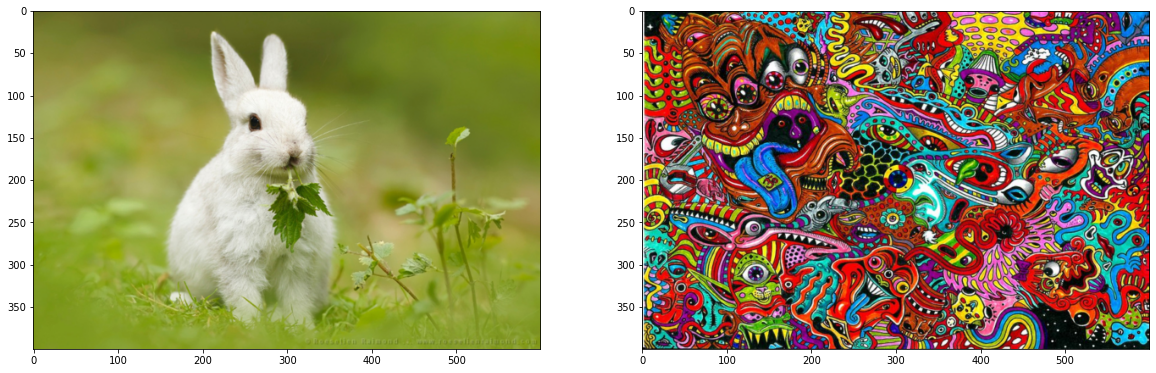

In [7]:
# Muestras las imageness
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# Imagenes de contenido y estilo lado a lado
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## Capas VGG19

Para obtener las representaciones de contenido y estilo de una imagen, tenemos que hacer pasar una imagen por la red VGG19 hasta llegar a la(s) capa(s) deseada(s) y luego obtener la salida de esa capa.

## Características de contenido y estilo


In [8]:
def get_features(image, model, layers=None):
    """ Pasar una imagen por un modelo y obtener las características de 
        un conjunto de capas. Las capas predeterminadas son para la coincidencia de VGGNet Gatys et al (2016)
    """
    
    ## Selección de las capas para las representaciones de contenido y estilo de una imagen
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## Representación del contenido
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules es un diccionario que contiene cada módulo del modelo
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Matriz Gram 

La salida de cada capa convolucional es un Tensor con dimensiones asociadas al `tamaño_del_batch`, una profundidad, `d`, una altura y anchura (`h`, `w`). La matriz Gram de una capa convolucional se puede calcular de la siguiente manera:
* Obteniendo la profundidad, altura y anchura de un tensor usando `tamaño_del_batch, d, h, w = tensor.size()`.
* Remodelar ese tensor para que las dimensiones espaciales se aplanen
* Calcular la matriz GRAM multiplicando el tensor  por su transpuesta. 


In [9]:
def gram_matrix(tensor):
    """ Calculo de la matriz de Gram de un tensor dado 
        Matriz de Gram: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # obtener el tamaño del lote, la profundidad, la altura y la anchura del tensor
    b, d, h, w = tensor.size()
    
    # Ajuste de tamañis, así que estamos multiplicando las características de cada canal
    tensor = tensor.view(b * d, h * w)
    
    #  Calculo de la matriz Gram
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Cómo unirlo todo

Ahora que hemos escrito las funciones para extraer las características y calcular la matriz Gram de una capa convolucional determinada, ¡vamos a unir todas estas piezas! Extraeremos las características de nuestras imágenes y calcularemos las matrices GRAM para cada capa en nuestra representación de estilo.

In [10]:
# obtiene las características de contenido y estilo sólo una vez antes de formar la imagen de destino
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calcula las matrices de gramos para cada capa de nuestra representación de estilo
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Crea una tercera imagen "objetivo" y la prepara para el cambio
# es una buena idea empezar con el objetivo como una copia de nuestra imagen de *contenido
# luego cambiamoa iterativamente su estilo
target = content.clone().requires_grad_(True).to(device)

---
## Loss y Weights

#### Weights de estilo de las capas individuales

A continuación, se le da la opción de ponderar la representación del estilo en cada capa relevante. Se sugiere utilizar un rango entre 0-1 para ponderar estas capas. Al ponderar más las capas anteriores (`conv1_1` y `conv2_1`), puede esperar obtener algunos objetos de la imagen de estilo en la imagen de objetivo resultante. Si elige ponderar las capas posteriores, obtendrá un mayor énfasis en las características más pequeñas. Esto se debe a que cada capa tiene un tamaño diferente y juntas crean una representación de estilo multiescala.

#### Contenido y Weights del estilo

Al igual que en el papel, definimos un alfa (`content_weight`) y un beta (`style_weight`). Esta proporción afectará a lo _estilizada_ que esté tu imagen final. Se recomienda dejar el peso_de_contenido = 1 y ajustar el peso_de_estilo para conseguir la proporción que desee.

In [11]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta

## Actualización de la imagen objetivo y calculalo de las pérdidas

Se debe decidir el número de pasos para actualizar su imagen sólo que estamos cambiando nuestra imagen _objetivo_ y nada más sobre VGG19. **Se recomienda usar al menos 2000 pasos para obtener buenos resultados, pero puede empezar con menos pasos si sólo está probando diferentes valores de peso o experimentando con diferentes imágenes.

Dentro del bucle de iteración, calculará las pérdidas de contenido y estilo y actualizará su imagen objetivo, en consecuencia.

#### Loss(pérdida) de contenido

La pérdida de contenido será la diferencia media al cuadrado entre las características del objetivo y del contenido en la capa `conv4_2`. Se puede calcular de la siguiente manera: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

####  Loss(pérdida) de estilo

El Loss de estilo se calcula de forma similar, sólo que hay que iterar a través de un número de capas, especificadas por nombre en nuestro diccionario `style_weights`. 
> Se Calcula la matriz de gram para la imagen objetivo, `target_gram` y la imagen de estilo `style_gram` en cada una de estas capas y se compara esas matrices de gram calculando el `layer_style_loss`. 
> Más adelante, verá que este valor está normalizado por el tamaño de la capa.

#### Pérdida total (Total Loss)

Finalmente, crearemos la pérdida total sumando las pérdidas de estilo y de contenido y ponderándolas con el alfa y la beta que hayamos especificado.

Imprimiremos esta pérdida; estas pérdidas pueden ser muy grandes. El estilo de una imagen tarda algún tiempo en cambiar y se centrar en la apariencia de la imagen objetivo más que en cualquier valor de pérdida. Aún así, debería ver que esta pérdida disminuye a lo largo de un cierto número de iteraciones.

In [12]:
# Se mostrara la imagen de destino de forma intermitente cada 400 iteraciones
show_every = 400

# hiperparámetros de iteración
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # Decide cuántas iteraciones son necesarias para actualizar su imagen (5000)

for ii in range(1, steps+1):
    
    # Se obtiene las características de su imagen objetivo
    target_features = get_features(target, vgg)
    
    # Pérdida de contenido
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # Pérdida de estilo
    # inicializa la pérdida de estilo en 0
    style_loss = 0
    # luego se le agrega la pérdida de la matriz gram de cada capa
    for layer in style_weights:
        # obtener la representación del estilo "objetivo" para la capa
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # obtenine la representación del estilo 
        style_gram = style_grams[layer]
        # la pérdida de estilo de una capa, ponderada adecuadamente
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # añade a la pérdida de estilo
        style_loss += layer_style_loss / (d * h * w)
        
    # calcula la pérdida *total*
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # actualiza la imagen de destino
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Muestra las imágenes intermedias e imprime la pérdida
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

KeyboardInterrupt: 

## Muestra la imagen objetivo

In [ ]:
# Muestra el contenido y la imagen final, de destino
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))